## The Partial Fourier Transform (PFT)

The Partial Fourier Transform (PFT) focuses on computing a specified part of Fourier coefficients, as opposed to performing the full Fast Fourier Transform (FFT) which calculates all coefficients and then cropping out the unnecessary values. This approach is most efficient when the data is very large and only a small subset of Fourier coefficients (e.g. the low-frequency components of a sparse signal) are needed, saving computation time and resources.

In this notebook, we will demonstrate:
- **1D PFT**: Application on one-dimensional signals.
- **2D PFT**: Application on two-dimensional data, such as images.

The implementations of these funcions can be found in the src folder. 

Applying the PFT consists of two steps:
1. Run all precomputation functions. These functions compute all data-independent components of the Fourier transform.
2. Run the PFT computation function. This function carries out the core computation of the PFT, consisting of matrix multiplications,
   batch Fourier transforms, and element-wise operations (i.e. Hadamard products) to produce the final result

*Note*: The PFT function implementations assume all data to be complex-valued. If the data is real-valued, one can simply cast it as a complex-valued array, keeping the real part as the data and setting the imaginary part to zero.

For full details on the algorithms and all provided notation, please refer to https://arxiv.org/pdf/2008.12559

In [1]:
from src.PFT1D import *
from src.PFT2D import *

import matplotlib.pyplot as plt
from PIL import Image

device = 'cpu'

## The 1D PFT 
In this section, we provide a demonstration of the one-dimensional PFT.

We begin by initializing the setup variables for the PFT. The notation is as follows:
- $N$ is the size of the one-dimensional array.
- $M$ is the desired output size.
- $\mu$ is the center Fourier coefficient.
- $p$ is a divisor of $N$.
- error is the error of tolerance for the approximating polynomial of the twiddle factors.

In [2]:
# PFT Setup Variables
N = 2**25
M = 2**15
mu = 0
p = 2**16
error = 'e-7'

Next, we initialize a random complex-valued data array of size $N$. We compute the FFT and manually crop out the low-frequency components of this array. This will be used to compare the accuracy of the PFT:

In [3]:
# Initialize Random Data Array
z1 = torch.complex(torch.rand(N, device=device), torch.zeros(N, device=device))

In [4]:
# Compute Full 1D FFT of Data Array
z1_fft = torch.fft.fft(z1.clone())
# Crop out only the -M to M Fourier coefficients of z
z1_fft_crop = torch.cat((z1_fft[-M:], z1_fft[:M+1]))

Now we perform all the precomputations for the PFT, consisting of all data-independent elements of the Fourier transform:

In [5]:
# Perform all necessary precomputations for the PFT
B, p, q, r = pft_configuration(N, M, mu, p, error, device=device)
z1_reshaped, m_mod, precomputed_prod = pft_precompute(z1.clone(), M, mu, p, q, r, device=device)

print(f"N, M = {N}, {M} // p, q, r = {p}, {q}, {r} // e = {error}")

N, M = 33554432, 32768 // p, q, r = 65536, 512, 10 // e = e-7


Using the precomputed values, we now perform the **main PFT computation**. This function (as well as the preceding precomputation functions) makes use of broadcasting in Python for fast tensor operations.

In [6]:
# Perform the 1D PFT computation
z1_pft = pft_computation(z1_reshaped, B, m_mod, precomputed_prod, device=device)

Taking the relative error between the 1D PFT compuatation and the manual crop of the full FFT, we observe that the result is very close to $0$, thus demonstrating the accuracy of the PFT:

In [7]:
# Compute the relative error between the z_fft_crop and z_pft
torch.norm(z1_pft - z1_fft_crop) / torch.norm(z1_fft_crop)

tensor(2.0584e-07)

## The 2D PFT 
In this section, we provide a demonstration of the two-dimensional PFT.

As before, we begin by initializing the setup variables for the PFT. The notation is a straightforward extension of the one-dimensional case:
- $N$ is a list of sizes $N_1$ and $N_2$ of the input matrix along each dimension.
- $M$ is a list of the crop size $M_1$ and $M_2$ of the Fourier transform along each dimension.
- $\mu$ is the center Fourier coefficient of the 2D Fourier transform along each dimension. 
- $p$ is a list of divisors $p_1$ and $p_2$ of $N_1$ and $N_2$, respectively.
- error is the error of tolerance for the approximating polynomial of the twiddle factors.

In [8]:
# PFT Setup Variables
N = [512, 512]
M = [64, 64]
mu = [0, 0]
p = [64, 64]
error = 'e-7'

For this demonstration, we will make use of a cameraman image which has size $512 \times 512$. This image can be resized as necessary:

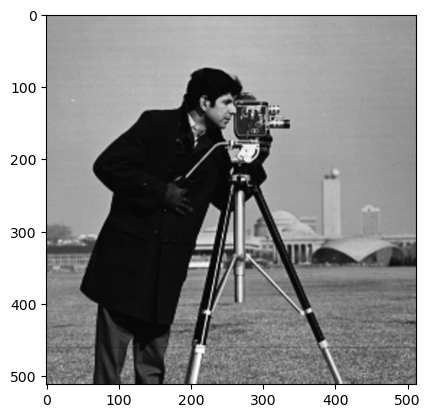

In [9]:
def resize_image(input_image_path, output_image_path, new_size):
    original_image = Image.open(input_image_path)
    width, height = original_image.size
    resized_image = original_image.resize(new_size)
    resized_image.save(output_image_path)

input_path = "src/cameraman.tif"
output_path = "src/cameraman_resized.png"

# SET SIZE OF IMAGE
nx = 512
new_size = (nx, nx)  # New size of the image (width, height)

resize_image(input_path, output_path, new_size)
im = np.array(Image.open('src/cameraman_resized.png').convert("L"))
z2 = torch.complex(torch.Tensor(im / np.max(im)), torch.zeros(nx, nx)).to(device)

plt.imshow(z2.real.cpu(), cmap='gray')
plt.show()

We compute the 2D FFT and manually crop out the low-frequency components of this image. This will be used to compare the accuracy of the 2D PFT:

In [10]:
# Compute Full 2D FFT of Data Array
z2_fft = torch.fft.fft2(z2.clone())

# Perform shifting to match the PFT output layout
z2_shifted = torch.fft.fftshift(z2_fft)

# Determine the indices corresponding to the rectangle [-M1, M1] x [-M2, M2]
start_idx_1 = N[0] // 2 - M[0]
end_idx_1 = N[0] // 2 + M[0]
start_idx_2 = N[1] // 2 - M[1]
end_idx_2 = N[1] // 2 + M[1]

# Extract the Fourier coefficients corresponding to the rectangle
z2_fft_crop = z2_shifted[start_idx_1:end_idx_1, start_idx_2:end_idx_2]

Now we perform all the precomputations for the PFT, consisting of all data-independent elements of the Fourier transform:

In [11]:
B, p, q, r = pft2d_configuration(N, M, mu, p, error, device=device)
z2_reshaped, m1_mod, m2_mod, precomputed_prod = pft2d_precompute(z2.clone(), M, mu, p, q, r, device=device)

print(f"N, M = {N[0], N[1]}, {M[0], M[1]} // p, q, r = {p}, {q}, {r} // e = {error}")

N, M = (512, 512), (64, 64) // p, q, r = [64, 64], [8, 8], [13, 13] // e = e-7


Using the precomputed values, we now perform the **main PFT computation**. This function (as well as the preceding precomputation functions) makes use of broadcasting in Python for fast tensor operations.

In [12]:
# Perform the 2D PFT computation
z2_pft2d = pft2d_computation(z2_reshaped, B, m1_mod, m2_mod, precomputed_prod, device=device)

Taking the relative error between the 2D PFT compuatation and the manual crop of the full FFT, we observe that the result is very close to $0$, thus demonstrating the accuracy of the 2D PFT:

In [13]:
# Compute the relative error between the z_fft_crop and z_pft
torch.norm(z2_pft2d - z2_fft_crop) / torch.norm(z2_fft_crop)

tensor(1.7452e-06)

Moreover, we can visually compare the computed Fourier coefficients via matplotlib. We plot the magnitude of the frequencies and note that the choice of $M = [64, 64]$ gives us a resulting cropped matrix of size $128 \times 128$:

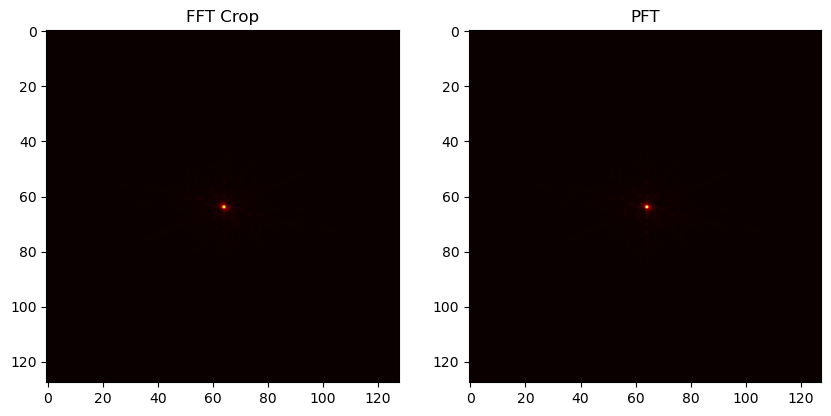

In [14]:
fig, axes = plt.subplots(1, 2, figsize=(10, 5))
cmap='hot'

# Display each image in a separate subplot
axes[0].imshow(torch.abs(z2_fft_crop), cmap=cmap)
axes[0].set_title('FFT Crop')

axes[1].imshow(torch.abs(z2_pft2d), cmap=cmap)
axes[1].set_title('PFT')

plt.show()